# DS-SF-30 | Final Project 3: Model Notebook
### Elizabeth Harwood
## Baseball Hall of Fame Prediction

# Summary and Plan from Final Proj Part 2

### Summary: 

Data exploration and visualization of player HallofFame table data. 

Added additional data from the following tables: 
* MASTER - Player names, DOB, and biographical info
* Fielding - Player teams, positions
* Salaries - player salary data
* AllStarFull - All-Star appearances
* Teams - yearly stats and standings
* PlayerAwards - awards given to individual players

Engineered the following features: 
* votes_percent
* mean_salary
* sum_salary
* max_salary
* allstarGameCount
* n_prev_noms
* Win_pct
* Tot_Wins
* Manager
* Pioneer/Executive
* Umpire
* P_Awards
 


### Analysis Plan: 

For exploring the factors influencing induction of nominees into the baseball hall of fame:

* Perform both Logistic Regression (y = 'inducted') and linear regression (y = 'votes_percent') to explore factors influencing both. 

* Scale data prior to modeling to ensure each feature has a similar influence on outcome

* Perform Lasso Regression starting with lots of features and removing those whose coefficients go to 0

* Perform Linear Regression with StatsModels to see the p-values of the coefficients and determine which should be removed from the model

* Possibly add more features from additional baseball data, such as Manager Awards, or specific player information like batting and pitching statistics, or number of people nominated to Hall of Fame that year

* Remove any rows in the dataframe with missing data, or else possibly decide to only model data for nominees of category 'player'

* Split data into a test and train data set (train set to be 20% of data, test remaining)

* Perform cross-validation for any model parameter selection

* Train model again using all train data

* Score model using test data to get an estimate of error rate

* Train model one last time on all data for final model.

Things to try: 
    
1) Logistic regression

2) Linear Regression 

2) b) with Lasso Regression

3) Decision Trees

# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from collections import defaultdict
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import numpy as np
import math

from sklearn import tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')

# Load Data from Project Part 2

In [2]:
path = os.path.join('..','data','project_data_processed','part_2_output.csv')
df_full = pd.read_csv(path)

In [3]:
df_full.head()

,playerID,HoF_Year,votedBy,inducted,category,votes_percent,mean_salary,...,W,Win_pct,Tot_Wins,Manager,Pioneer/Executive,Umpire,P_Awards
0,cobbty01,1936,BBWAA,1,Player,1.305882,NaN,...,1949.0,0.530079,3.0,0.0,0.0,0.0,31
1,ruthba01,1936,BBWAA,1,Player,1.264706,NaN,...,1957.0,0.582856,17.0,0.0,0.0,0.0,33
2,wagneho01,1936,BBWAA,1,Player,1.264706,NaN,...,1735.0,0.546518,5.0,0.0,0.0,0.0,12
3,mathech01,1936,BBWAA,1,Player,1.205882,NaN,...,1516.0,0.550792,6.0,0.0,0.0,0.0,15
4,johnswa01,1936,BBWAA,1,Player,1.111765,NaN,...,1559.0,0.484631,3.0,0.0,0.0,0.0,33


# Summary of Features

In [4]:
print(df_full.columns.tolist())

['playerID', 'HoF_Year', 'votedBy', 'inducted', 'category', 'votes_percent', 'mean_salary', 'sum_salary', 'max_salary', 'allstarGameCount', 'n_prev_noms', 'W', 'Win_pct', 'Tot_Wins', 'Manager', 'Pioneer/Executive', 'Umpire', 'P_Awards']


* playerID - Unique id for all players in the dataset (not a feature)
* HoF_Year - Year of this particular vote; might be included in feature set
* votedBy - Association/Committee voting on induction; might be used to remove data
* inducted - binary varible; outcome for logistic regression
* category - Type of role of nominee; might be used to remove data
* votes_percent - continuous variable; outcome for linear regression
* mean_salary - Average of all salaries drawn by player; only one salary variable will be considered for inclusion
* sum_salary - Sum of all salaries drawn by player; only one salary variable will be considered for inclusion
* max_salary - Max of all salaries drawn by player; only one salary variable will be considered for inclusion
* allstarGameCount - Number of all star games the nominee was part of; probable feature
* n_prev_noms - Number of previous nominations for the nominee; probable feature
* W - Total number of wins by the team the player was a part of; only one of 'W' or 'Win_pct' will be considered for inclusion
* Win_pct - % of games won by the team the player was a part of; only one of 'W' or 'Win_pct' will be considered for inclusion
* Tot_Wins - Number of postseason title games won by the team the player was a part of; probable feature
* Manager - binary varible; if the nominee is a manager
* Pioneer/Executive - binary varible; if the nominee is a Pioneer/Exec
* Umpire - binary varible; if the nominee is an Umpire
* P_Awards - number of individual awards won by the player; probable feature

## Renaming Columns

A few of the columns have long or confusing names, so I'll fix that now

In [5]:
df_full = df_full.rename(columns={'HoF_Year': 'HoF_Yr', 'n_prev_noms':'Prev_Nom',
                                  'allstarGameCount':'AllstarGm','votes_percent': 'Vote_Pct',
                                  'mean_salary':'Mean_Sal','sum_salary':'Sum_Sal','max_salary':'Max_Sal'})

# Adding more data

My dataset does not yet include data for player statistics, like pitching and batting, which are likely very important for prediction of Hall of Fame induction, so I will add that data to my dataset now. 

## Batting Data

In [6]:
batting_df = pd.read_csv(os.path.join('..','data','baseballdatabank-master', 'core','Batting.csv'))
print(batting_df.shape)
batting_df.head()

(101332, 22)


,playerID,yearID,stint,teamID,lgID,G,AB,...,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,...,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,...,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [7]:
batting_df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')

2.2 Batting Table
* playerID:       Player ID code
* yearID:         Year
* stint:          player's stint (order of appearances within a season)
* teamID:         Team
* lgID:           League
* G:              Games
* AB:             At Bats
* R:              Runs
* H:              Hits
* 2B:             Doubles
* 3B:             Triples
* HR:             Homeruns
* RBI:            Runs Batted In
* SB:             Stolen Bases
* CS:             Caught Stealing
* BB:             Base on Balls
* SO:             Strikeouts
* IBB:            Intentional walks
* HBP:            Hit by pitch
* SH:             Sacrifice hits
* SF:             Sacrifice flies
* GIDP:           Grounded into double plays

Due to rules about induction and nomination into the baseball Hall of Fame, I know that any player must have been retired for at least 5 years (or dead) to be eligible for induction, so any data from the player's batting or pitching tables will be information from their record that took place prior to any HoF vote, so it can all be included regardless of year. Now I just have to determine how to include it. I think that some statistics should be added, and others should be counted (like number of seasons with batting averages in the top 5 or 10%) or else averaged. 

In [8]:
# Only want to use stints where the player played at least 10 games
batting_df = batting_df[batting_df.G >=10]
batting_df.shape

(80462, 22)

I want batting average, which is defined as the number of hits divided by the number of at bats. 

In [9]:
batting_df['BA'] = batting_df.H / batting_df.AB

#### Feature: Number of seasons in top 10% of batting averages

In [10]:
# want to find the top 10% of batting averages out of the ones that aren't null
ba_top10 = batting_df.BA.dropna().quantile(.9)
print(ba_top10)
# making a new feature, number of years with a top 10% batting average
batting_df['ba_top10'] = batting_df.BA >= ba_top10 

0.30612244898


In [11]:
# want it in binary
batting_df['ba_top10'] = batting_df['ba_top10'] * 1
# this will be aggregated by player
batting_df_by_player = batting_df.groupby(['playerID']).ba_top10.sum()
batting_df_by_player = pd.DataFrame(batting_df_by_player)

#### Feature: Number of average batting average (over all seasons)

In [12]:
# groupby player, take mean
batting_df_by_player['avg_ba'] = batting_df.groupby(['playerID']).BA.mean()

#### Feature: Number of Runs (cumulative over all seasons)

In [13]:
# groupby player, take mean
batting_df_by_player['sum_R'] = batting_df.groupby(['playerID']).R.sum()

#### Feature: Number of Home Runs (cumulative over all seasons)

In [14]:
# groupby player, take mean
batting_df_by_player['sum_HR'] = batting_df.groupby(['playerID']).HR.sum()

In [15]:
print(batting_df_by_player.count())
batting_df_by_player.head()

ba_top10    14304
avg_ba      13303
sum_R       14005
sum_HR      14005
dtype: int64


,ba_top10,avg_ba,sum_R,sum_HR
playerID,,,,
aardsda01,0,0.000000,0.0,0.0
aaronha01,12,0.301075,2174.0,755.0
aaronto01,0,0.226187,101.0,13.0
aasedo01,0,0.000000,0.0,0.0
abadfe01,0,0.071429,0.0,0.0


In [16]:
batting_df_by_player.dropna().corr()

,ba_top10,avg_ba,sum_R,sum_HR
ba_top10,1.000000,0.325180,0.642274,0.431280
avg_ba,0.325180,1.000000,0.353723,0.250362
sum_R,0.642274,0.353723,1.000000,0.788429
sum_HR,0.431280,0.250362,0.788429,1.000000


These variables are highly correlated, so I'll only use one or two of them in my ultimate model. 

## Pitching Data

In [17]:
pitching_df = pd.read_csv(os.path.join('..','data','baseballdatabank-master', 'core','Pitching.csv'))
print(pitching_df.shape)
pitching_df.head()

(44139, 30)


,playerID,yearID,stint,teamID,lgID,W,L,...,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,...,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,...,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,...,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,...,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,...,0,NaN,NaN,21,NaN,NaN,NaN


### 2.3 Pitching table - columns and descriptions

* playerID:       Player ID code
* yearID:         Year
* stint:          player's stint (order of appearances within a season)
* teamID:         Team
* lgID:           League
* W:              Wins
* L:              Losses
* G:              Games
* GS:             Games Started
* CG:             Complete Games 
* SHO:            Shutouts
* SV:             Saves
* IPOuts:         Outs Pitched (innings pitched x 3)
* H:              Hits
* ER:             Earned Runs
* HR:             Homeruns
* BB:             Walks
* SO:             Strikeouts
* BAOpp:          Opponent's Batting Average
* ERA:            Earned Run Average
* IBB:            Intentional Walks
* WP:             Wild Pitches
* HBP:            Batters Hit By Pitch
* BK:             Balks
* BFP:            Batters faced by Pitcher
* GF:             Games Finished
* R:              Runs Allowed
* SH:             Sacrifices by opposing batters
* SF:             Sacrifice flies by opposing batters
* GIDP:           Grounded into double plays by opposing batter

#### Fields to engineer: 
shutouts, strikeouts, BAOpp (opponent's batting avg), and R ( runs allowed, but need to rename that column)

#### Feature: Opponent's Batting Average (average of those)

In [18]:
pitching_df_by_player = pitching_df.groupby(['playerID']).BAOpp.mean()
pitching_df_by_player = pd.DataFrame(pitching_df_by_player)

#### Feature: Strikeouts (sum over all seasons)

In [19]:
# groupby player, aggregate
pitching_df_by_player['StrikeOuts'] = pitching_df.groupby(['playerID']).SO.sum()

#### Feature: Shutouts (sum over all seasons)

In [20]:
# groupby player, aggregate
pitching_df_by_player['ShutOuts'] = pitching_df.groupby(['playerID']).SHO.sum()

#### Feature: Runs Allowed (sum over all seasons)

In [21]:
# groupby player, aggregate
pitching_df_by_player['R_Allowed'] = pitching_df.groupby(['playerID']).R.sum()

In [22]:
print(pitching_df_by_player.count())
pitching_df_by_player.head()

BAOpp         8822
StrikeOuts    9126
ShutOuts      9126
R_Allowed     9126
dtype: int64


,BAOpp,StrikeOuts,ShutOuts,R_Allowed
playerID,,,,
aardsda01,0.257111,340,0,169
aasedo01,0.246923,641,5,503
abadfe01,0.255667,193,0,99
abbeybe01,0.295000,161,0,442
abbeych01,0.510000,0,0,3


In [23]:
# by definition, the .mean() method used on BAOpp drops na values and only gives a result of NA if all 
# of the inputs were NA, so I am going to ignore NA values for now
pitching_df_by_player.dropna().corr()

,BAOpp,StrikeOuts,ShutOuts,R_Allowed
BAOpp,1.000000,-0.040817,-0.003095,-0.019576
StrikeOuts,-0.040817,1.000000,0.758375,0.878033
ShutOuts,-0.003095,0.758375,1.000000,0.796442
R_Allowed,-0.019576,0.878033,0.796442,1.000000


As suspected, many of these variables are highly correlated (R_Allowed and Strikeouts, for example) so I'll ultimately only include one or possibly two in my model

## Fielding Table

In [24]:
fielding_df = pd.read_csv(os.path.join('..','data','baseballdatabank-master', 'core','Fielding.csv'))
print(fielding_df.shape)
fielding_df.head()

(170526, 18)


,playerID,yearID,stint,teamID,lgID,POS,G,...,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,...,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,...,42.0,5.0,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,...,7.0,0.0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,...,7.0,1.0,NaN,NaN,NaN,NaN,NaN


#### 2.4 Fielding Table (abbreviated description)

* playerID:       Player ID code
* yearID:         Year
* stint:          player's stint (order of appearances within a season)
* teamID:         Team
* lgID:           League
* Pos:            Position

In [25]:
fielding_df.POS.unique()

array(['SS', '2B', 'OF', 'C', '1B', '3B', 'P', 'LF', 'RF', 'CF', 'DH'], dtype=object)

In [26]:
# Looks like P is pitcher. Really I want to know if a player is a pitcher or not
fielding_df['Pitcher'] = fielding_df.POS.map(lambda x: 1 if x == 'P' else 0)

In [27]:
fielding_df.Pitcher.value_counts()

0    126385
1     44141
Name: Pitcher, dtype: int64

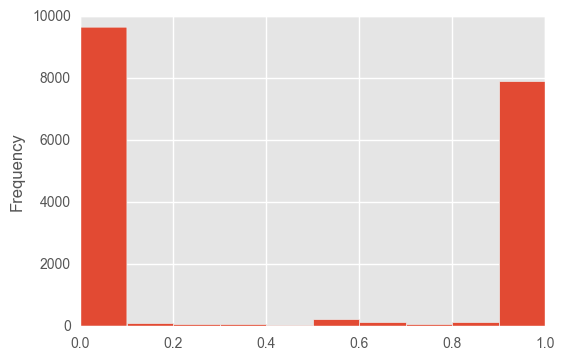

In [28]:
pitcher_by_player = fielding_df.groupby('playerID').Pitcher.mean()
pitcher_by_player.plot(kind='hist')

Looks like the majority of players are either always classified as a pitcher or never. So for simplicity, I will classify any player whose % pitcher assignment is over 0.8 as a pitcher, and the rest no. 

In [29]:
pitcher_by_player = pd.DataFrame(pitcher_by_player.map(lambda x: 1 if x >= 0.8 else 0)) 

In [30]:
pitcher_by_player.Pitcher.value_counts()

0    10412
1     8053
Name: Pitcher, dtype: int64

## Add new fields to new df_all, keep all features handy

In [31]:
df_all = df_full.merge(pitching_df_by_player,how='left',
                        left_on='playerID',right_index=True)

In [32]:
df_all = df_all.merge(batting_df_by_player,how='left',
                        left_on='playerID',right_index=True)

In [33]:
df_all = df_all.merge(pitcher_by_player,how='left',
                        left_on='playerID',right_index=True)

## Deal with null values

In [34]:
pd.set_option('display.max_rows', 40)
df_all.isnull().sum()

playerID                0
HoF_Yr                  0
votedBy                 0
inducted                0
category                0
Vote_Pct              350
Mean_Sal             3410
Sum_Sal              3410
Max_Sal              3410
AllstarGm            1620
Prev_Nom                0
W                      70
Win_pct                70
Tot_Wins               70
Manager                 0
Pioneer/Executive       0
Umpire                  0
P_Awards                0
BAOpp                2542
StrikeOuts           2536
ShutOuts             2536
R_Allowed            2536
ba_top10               71
avg_ba                 88
sum_R                  72
sum_HR                 72
Pitcher                70
dtype: int64

#### Null Values in feature: All Star Game Count

Feature 'AllstarGm' has null values for 39% of data points. Looking at the data table, this information is only available for years since 1933, and since individuals must be retired for 5 years before they are eligible for nomination, likely it will be older rounds of voting that have null values for 'AllstarGm'. 

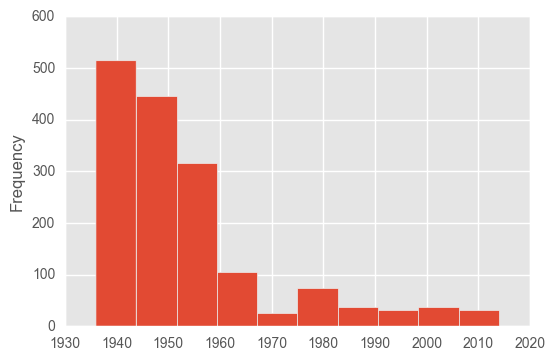

In [35]:
df_all[df_all.AllstarGm.isnull()].HoF_Yr.plot(kind='hist')

As I thought, older nominees are missing information about All Star game participation, and any later null values are likely due to the person not being in any all star games, perhaps because they were a manager or exec? 

In [36]:
df_all[(df_all.AllstarGm.isnull())&(df_all.HoF_Yr > 1960)].category.value_counts()

Player               239
Pioneer/Executive     21
Manager               16
Umpire                 8
Name: category, dtype: int64

Mostly missing data is for players, even after 1960, so I will assume those players were not in any all star games and set missing vals to 0. 

In [37]:
df_all.AllstarGm = df_all.AllstarGm.map(lambda x: 0 if math.isnan(x) else x)
df_all.AllstarGm.isnull().sum()

0

#### Null Values in feature: Vote_Pct

In [38]:
df = pd.read_csv(os.path.join('..','data','baseballdatabank-master', 'core','HallOfFame.csv'))

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Data columns (total 9 columns):
playerID       4120 non-null object
yearid         4120 non-null int64
votedBy        4120 non-null object
ballots        3927 non-null float64
needed         3770 non-null float64
votes          3927 non-null float64
inducted       4120 non-null object
category       4120 non-null object
needed_note    157 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 289.8+ KB


I realized, going back over the original data set from EDA, that the number of data points with no value for 'needed' (but that did have a value for 'votes') was 157, the exact number of data points with a non-null value for needed_note. I will explore if those seemed to follow the rule for needing votes of 75% of the number of ballots, or if there were other criteria, and what the notes are. 

In [40]:
df.needed_note.value_counts()

1st       81
Top 20    76
Name: needed_note, dtype: int64

Looks like two alternative criteria for how a player could get voted in. 

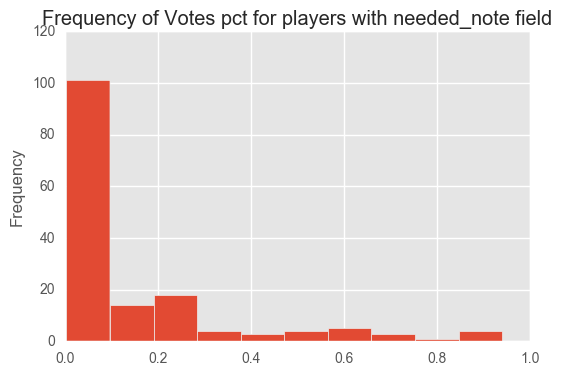

In [41]:
a = df[df.needed_note.notnull()]
a.vot_pct_2   = a.votes / a.ballots
a.vot_pct_2.plot(kind='hist',title = 'Frequency of Votes pct for players with needed_note field')

In [42]:
df[df.needed_note.notnull()].inducted.value_counts()

N    154
Y      3
Name: inducted, dtype: int64

In [43]:
df[(df.needed_note.notnull()) & (df.inducted == 'Y')].votes / \
    df[(df.needed_note.notnull()) & (df.inducted == 'Y')].ballots

896     0.850267
1969    0.940299
2114    0.869281
dtype: float64

As hoped, the players voted in still had the requisite 75% of ballots for votes, so I will fill in those null values for Vote_Pct with the number needed. 

In [44]:
max(df[(df.needed_note.notnull()) & (df.inducted == 'N')].votes / \
    df[(df.needed_note.notnull()) & (df.inducted == 'N')].ballots)

0.91542288557213936

In [45]:
df[(df.needed_note.notnull()) & (df.inducted == 'N')].category.value_counts()

Player    154
Name: category, dtype: int64

In [46]:
df[(df.needed_note.notnull()) & (df.inducted == 'N')].votedBy.value_counts()
# I'm going to drop these, all not inducted and special circumstances = noise

Run Off            78
Nominating Vote    76
Name: votedBy, dtype: int64

I could drop just these, but remembering how the chance of induction varied wildly depending on the 'votedOn' field, I will drop all that aren't 'votedOn' by 'BBWAA'.

In [47]:
ct_vb = pd.crosstab(df.votedBy, df.inducted)
ct_vb['success_rate'] = ct_vb.apply(lambda x: x[1] / (x[0] + x[1]) ,axis=1)
ct_vb

inducted,N,Y,success_rate
votedBy,,,
BBWAA,3573,116,0.031445
Centennial,0,6,1.000000
Final Ballot,21,0,0.000000
Negro League,0,26,1.000000
Nominating Vote,76,0,0.000000
Old Timers,0,30,1.000000
Run Off,78,3,0.037037
Special Election,0,2,1.000000
Veterans,60,129,0.682540


In [48]:
# df_clean will be clean version, df_all has all features still in it
df_clean = df_all.drop(df[df.votedBy != 'BBWAA'].index)

In [49]:
df_clean.Vote_Pct.isnull().sum()

0

#### Null values in feature: Pitcher

In [50]:
df_clean.Pitcher.isnull().sum()

6

In [51]:
df_clean[df_clean.Pitcher.isnull()].category.value_counts()

Manager    5
Player     1
Name: category, dtype: int64

In [52]:
# set Pitcher to 0 if the inductee is anything but a player
df_clean.Pitcher = df_clean.apply(lambda x: 0 if x['category'] != 'Player' else x['Pitcher'], axis=1)

In [53]:
df_clean[df_clean.Pitcher.isnull()].category.value_counts()

Player    1
Name: category, dtype: int64

In [54]:
# check if remaining players with null for pitcher have pitching data
df_clean[df_clean.Pitcher.isnull()].R_Allowed.notnull().sum()

0

In [55]:
# none of remaining players have pitching data, so I'll say that none of them are pitchers
df_clean.Pitcher = df_clean.Pitcher.map(lambda x: x if x == 1 else 0)

In [56]:
ct_Pitcher = pd.crosstab(df_clean.Pitcher, df_clean.inducted)
ct_Pitcher['success_rate'] = ct_Pitcher.apply(lambda x: x[1] / (x[0] + x[1]) ,axis=1)
ct_Pitcher

inducted,0,1,success_rate
Pitcher,,,
0.0,2519,77,0.029661
1.0,1054,39,0.035682


#### Null values in features: BAOpp, StrikeOuts, ShutOuts, R_Allowed ( all pitcher stats)

In [57]:
df_clean[df_clean.R_Allowed.isnull()].Pitcher.value_counts()

0.0    2265
Name: Pitcher, dtype: int64

In [58]:
# if not a pitcher and runs allowed field ('R_Allowed') is null, set to zero
df_clean.R_Allowed = df_clean.apply(lambda x: 0 if (x['Pitcher'] == 0 and \
                                                  math.isnan(x['R_Allowed'])) else x['R_Allowed'] , axis=1)

In [59]:
# did it work? 
print(df_clean.R_Allowed.isnull().sum())

0


In [60]:
# Same with other three variables listed above

# if not a pitcher and StrikeOuts field is null, set to zero
df_clean.StrikeOuts = df_clean.apply(lambda x: 0 if (x['Pitcher'] == 0 and \
                                                  math.isnan(x['StrikeOuts'])) else x['StrikeOuts'] , axis=1)
# if not a pitcher and ShutOuts field is null, set to zero
df_clean.ShutOuts = df_clean.apply(lambda x: 0 if (x['Pitcher'] == 0 and \
                                                  math.isnan(x['ShutOuts'])) else x['ShutOuts'] , axis=1)
# if not a pitcher and batting avg of opponent field ('BAOpp') is null, set to zero
df_clean.BAOpp = df_clean.apply(lambda x: 0 if (x['Pitcher'] == 0 and \
                                                  math.isnan(x['BAOpp'])) else x['BAOpp'] , axis=1)

In [61]:
# results
print('Number of null values remaining in "R_Allowed" field: {}'.format(df_clean.R_Allowed.isnull().sum()))
print('Number of null values remaining in "StrikeOuts" field: {}'.format(df_clean.StrikeOuts.isnull().sum()))
print('Number of null values remaining in "ShutOuts" field: {}'.format(df_clean.ShutOuts.isnull().sum()))
print('Number of null values remaining in "BAOpp" field: {}'.format(df_clean.BAOpp.isnull().sum()))

Number of null values remaining in "R_Allowed" field: 0
Number of null values remaining in "StrikeOuts" field: 0
Number of null values remaining in "ShutOuts" field: 0
Number of null values remaining in "BAOpp" field: 0


#### Null values in features: avg_ba, sum_R, sum_HR

What are the characteristics of individuals with null values for batting statistics?

In [62]:
df_clean[df_clean.avg_ba.isnull()].Pitcher.value_counts()

0.0    15
1.0     8
Name: Pitcher, dtype: int64

In [63]:
df_clean[df_clean.avg_ba.isnull()].category.value_counts()

Player     18
Manager     5
Name: category, dtype: int64

In [64]:
df_clean[df_clean.category == 'Manager'].avg_ba.value_counts()

0.272256    9
0.273598    8
0.262965    7
0.267780    7
0.247004    6
0.272636    5
0.238999    3
0.316841    1
Name: avg_ba, dtype: int64

In [65]:
df_clean[df_clean.avg_ba.isnull()].playerID.value_counts()[:4]

guidrro01    9
mccarjo99    5
boddimi01    1
leonade01    1
Name: playerID, dtype: int64

In [66]:
df_clean[df_clean.sum_R.isnull()].playerID.value_counts()[:4]

mccarjo99    5
mcdowja01    1
nomohid01    1
Name: playerID, dtype: int64

Not very many missing, not sure what to do for now. 

#### Null values in features: Salary info

In [67]:
df_clean.Mean_Sal.isnull().sum()

2979

Going to drop salary info, as it was missing in  majority of data points. 

In [68]:
df_clean = df_clean.drop(['Mean_Sal','Sum_Sal','Max_Sal'],axis=1)
df_clean.isnull().sum()

playerID              0
HoF_Yr                0
votedBy               0
inducted              0
category              0
Vote_Pct              0
AllstarGm             0
Prev_Nom              0
W                     6
Win_pct               6
Tot_Wins              6
Manager               0
Pioneer/Executive     0
Umpire                0
P_Awards              0
BAOpp                 0
StrikeOuts            0
ShutOuts              0
R_Allowed             0
ba_top10              6
avg_ba               23
sum_R                 7
sum_HR                7
Pitcher               0
dtype: int64

In [69]:
df_clean[df_clean.isnull().sum(axis=1) > 0].inducted.value_counts()

0    23
Name: inducted, dtype: int64

While I would normally think harder about dropping data points, since all are 0 for inducted, and I am going to need to downsample inducted == 0  anyways, I will drop all remaining data points with null values in order to be able to continue with clean data. 

In [70]:
df_clean = df_clean.dropna()


In [71]:
df_clean.category.value_counts()

Player               3613
Manager                46
Pioneer/Executive       7
Name: category, dtype: int64

Finally, for linear regression, I will drop all data points that aren't Players. 

In [72]:
df_clean = df_clean[df_clean.category == 'Player']

In [73]:
df_clean.columns

Index(['playerID', 'HoF_Yr', 'votedBy', 'inducted', 'category', 'Vote_Pct',
       'AllstarGm', 'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'Manager',
       'Pioneer/Executive', 'Umpire', 'P_Awards', 'BAOpp', 'StrikeOuts',
       'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R', 'sum_HR',
       'Pitcher'],
      dtype='object')

In [74]:
df_clean = df_clean[['playerID', 'HoF_Yr', 'votedBy', 'inducted', 'Vote_Pct',
       'AllstarGm', 'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp', 'StrikeOuts',
       'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R', 'sum_HR',
       'Pitcher']]
print(df_clean.shape)
print(df_clean.isnull().sum().sum())

(3613, 20)
0


# Data Summary
How many total data points do we have, and how many of each outcome (inducted vs not) do we have?

In [75]:
len(df_clean)

3613

In [76]:
df_inducted = pd.DataFrame(df_clean.inducted.value_counts()).transpose()
df_inducted['success_rate'] = df_inducted.apply(lambda x: x[1] / (x[0] + x[1]) ,axis=1)
df_inducted

,0,1,success_rate
inducted,3497,116,0.032106


In [77]:
df_clean.columns

Index(['playerID', 'HoF_Yr', 'votedBy', 'inducted', 'Vote_Pct', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher'],
      dtype='object')

inducted
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: HoF_Yr, dtype: object

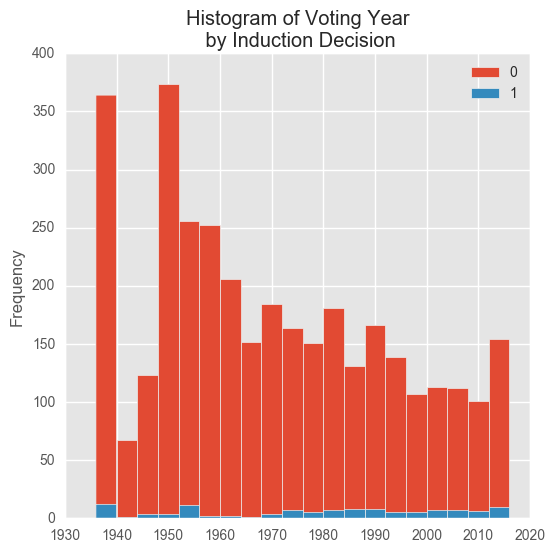

In [78]:
df_clean.groupby('inducted').HoF_Yr.plot(kind='hist',figsize = (6, 6),bins=20,
                                   sharex=True, sharey=True,legend=True,
                                title='Histogram of Voting Year\n by Induction Decision')

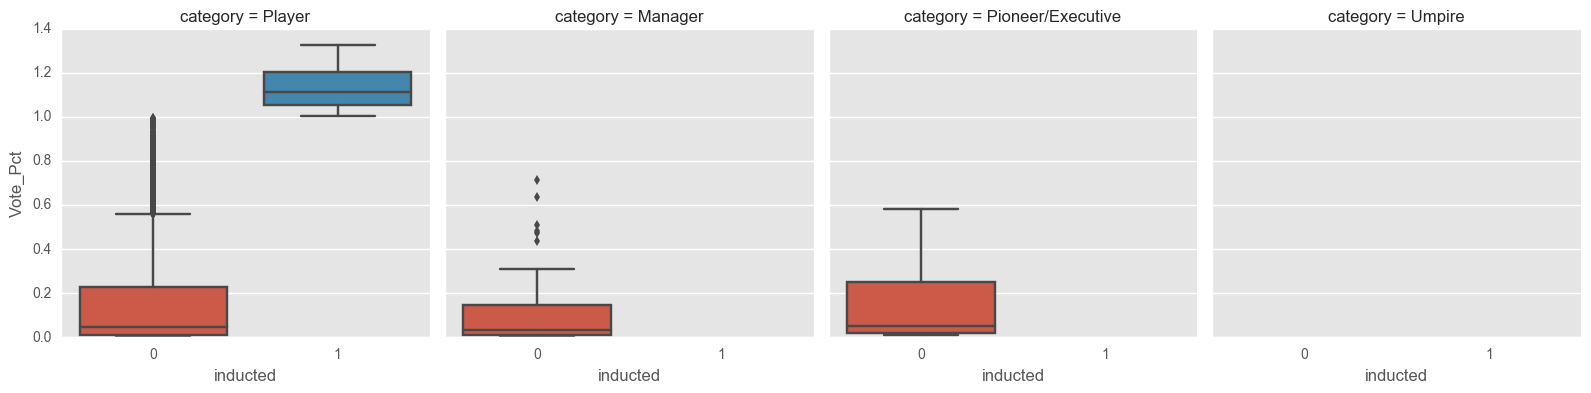

In [79]:
sns.factorplot(col = 'category',
              x = 'inducted',
              y = 'Vote_Pct',
              data = df_all,
              kind = 'box')

# Test/Train Split

I will use 80% of the data for training, and save 20% to test the accuracy of the resulting models. Out of the 80% for train data, I will split into a training and a validation set for each of my models to pick the hyper parameters. 

In [80]:
train_df = df_clean.sample(frac = .8, random_state = 0).sort_index()
test_df = df_clean.drop(train_df.index)

Just to see what happened with the random split, I'll check out how many of each 

In [81]:
df_train_inducted = pd.DataFrame(train_df.inducted.value_counts()).transpose()
df_train_inducted['success_rate'] = df_train_inducted.apply(lambda x: x[1] / (x[0] + x[1]) ,axis=1)
df_train_inducted

,0,1,success_rate
inducted,2797,93,0.03218


In [82]:
df_test_inducted = pd.DataFrame(test_df.inducted.value_counts()).transpose()
df_test_inducted['success_rate'] = df_test_inducted.apply(lambda x: x[1] / (x[0] + x[1]) ,axis=1)
df_test_inducted

,0,1,success_rate
inducted,700,23,0.031812


In [83]:
df_clean.corr()

,HoF_Yr,inducted,Vote_Pct,AllstarGm,Prev_Nom,W,Win_pct,...,ShutOuts,R_Allowed,ba_top10,avg_ba,sum_R,sum_HR,Pitcher
HoF_Yr,1.000000,0.068966,0.187495,0.455396,0.038214,0.235069,-0.120453,...,-0.068761,-0.012002,-0.180874,-0.215536,0.030445,0.351362,0.074803
inducted,0.068966,1.000000,0.599123,0.231320,-0.014371,0.161452,0.029580,...,0.073788,0.040421,0.103309,0.013647,0.111705,0.141768,0.014265
Vote_Pct,0.187495,0.599123,1.000000,0.494594,0.311366,0.335370,0.088083,...,0.113230,0.056358,0.194150,0.017422,0.222031,0.267715,0.004108
AllstarGm,0.455396,0.231320,0.494594,1.000000,0.163685,0.265495,0.137136,...,-0.099369,-0.136721,0.112881,0.095693,0.303958,0.472479,-0.129826
Prev_Nom,0.038214,-0.014371,0.311366,0.163685,1.000000,0.125102,0.086444,...,0.042810,0.028804,0.122692,0.086177,0.087530,0.041084,-0.028206
W,0.235069,0.161452,0.335370,0.265495,0.125102,1.000000,0.087241,...,0.210665,0.276886,0.134078,-0.083496,0.160482,0.127904,0.116846
Win_pct,-0.120453,0.029580,0.088083,0.137136,0.086444,0.087241,1.000000,...,0.036859,-0.022802,0.013961,0.085914,0.041088,-0.025526,-0.028693
Tot_Wins,0.176128,0.082705,0.140911,0.166969,0.016757,0.321468,0.610637,...,0.082021,0.085571,-0.079079,-0.069813,-0.026629,0.051375,0.069724
P_Awards,0.129947,0.285740,0.480330,0.518201,0.165843,0.254793,0.139483,...,-0.064112,-0.109203,0.363274,0.240149,0.369450,0.417420,-0.149810
BAOpp,-0.110838,-0.013072,-0.051227,-0.204214,-0.032125,0.058404,0.016585,...,0.591214,0.607215,-0.321752,-0.498330,-0.548985,-0.415742,0.568154


# First Model: Linear Regression

## Baseline Model

As a way to see what the starting point is for my model's ability to predict the induction outcome, I will make a preliminary model with the simplest features so that I can compare the success rate with future iterations. 

In [84]:
X = train_df

y = train_df.Vote_Pct

train_X, val_X, train_y, val_y = cross_validation.train_test_split(X, y, train_size = .6, random_state = 0)

In [85]:
smf.ols(formula = 'Vote_Pct ~ HoF_Yr + AllstarGm + Prev_Nom + Tot_Wins + Win_pct + W + P_Awards + BAOpp +StrikeOuts+ ShutOuts + R_Allowed + ba_top10 + avg_ba + sum_R + sum_HR + Pitcher', 
        data = train_X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Vote_Pct   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     100.8
Date:                Tue, 21 Feb 2017   Prob (F-statistic):          4.26e-233
Time:                        14:25:58   Log-Likelihood:                 245.44
No. Observations:                1734   AIC:                            -456.9
Df Residuals:                    1717   BIC:                            -364.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.2778      0.656      4.994      0.000         1.990     4.565
HoF_Yr        -0.0016      0.000     -5.127      0.000        -0.002    -0.001
AllstarGm      0.0201      0.002     10.840      0.000         0.016     0.024
Prev_Nom       0.0153      0.001     11.902      0.000         0.013     0.018
Tot_Wins       0.0042      0.002      2.382      0.017         0.001     0.008
Win_pct       -0.2896      0.178     -1.626      0.104        -0.639     0.060
W           3.859e-05    2.2e-05      1.757      0.079     -4.49e-06  8.17e-05
P_Awards       0.0087      0.001      7.908      0.000         0.007     0.011
BAOpp          0.0083      0.035      0.236      0.813        -0.061     0.077
StrikeOuts     0.0002   1.87e-05     10.742      0.000         0.000     0.000
ShutOuts       0.0015      0.001      1.666      0.096        -0.000     0.003
R_Allowed     -0.0002   2.51e-05     -6.050      0.000        -0.000    -0.000
ba_top10       0.0023      0.002      0.981      0.327        -0.002     0.007
avg_ba        -0.6243      0.165     -3.783      0.000        -0.948    -0.301
sum_R          0.0002    2.5e-05      6.504      0.000         0.000     0.000
sum_HR         0.0003   6.24e-05      4.691      0.000         0.000     0.000
Pitcher        0.0126      0.025      0.496      0.620        -0.037     0.063
==============================================================================
Omnibus:                      330.168   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.912
Skew:                           1.084   Prob(JB):                    9.46e-156
Kurtosis:                       5.276   Cond. No.                     3.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
model = smf.ols(formula = 'Vote_Pct ~ HoF_Yr + AllstarGm + Prev_Nom + P_Awards + avg_ba + sum_R', 
        data = train_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Vote_Pct   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     190.6
Date:                Tue, 21 Feb 2017   Prob (F-statistic):          1.52e-186
Time:                        14:25:58   Log-Likelihood:                 111.66
No. Observations:                1734   AIC:                            -209.3
Df Residuals:                    1727   BIC:                            -171.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.5224      0.568      2.679      0.007         0.408     2.637
HoF_Yr        -0.0007      0.000     -2.335      0.020        -0.001    -0.000
AllstarGm      0.0235      0.002     12.274      0.000         0.020     0.027
Prev_Nom       0.0155      0.001     11.470      0.000         0.013     0.018
P_Awards       0.0128      0.001     11.632      0.000         0.011     0.015
avg_ba        -1.3184      0.140     -9.445      0.000        -1.592    -1.045
sum_R          0.0001   1.79e-05      7.756      0.000         0.000     0.000
==============================================================================
Omnibus:                      492.948   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1354.710
Skew:                           1.480   Prob(JB):                    6.74e-295
Kurtosis:                       6.160   Cond. No.                     2.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
# Many issues with this model,need to upsample

# Upsampling

In [88]:
def return_sampled_df(df):
    print(df.inducted.value_counts())
    inducted_counts = df.inducted.value_counts()
    
    df_new = df.copy()
    
    for induction in [0, 1]:
        n = inducted_counts[induction] - inducted_counts.min()
        index = df[df.inducted == induction].sample(n = n).index
        df_new.drop(index,inplace=True)
    
    print(df_new.inducted.value_counts())
    return df_new

In [89]:
sampled_df = return_sampled_df(train_df)

0    2797
1      93
Name: inducted, dtype: int64
1    93
0    93
Name: inducted, dtype: int64


In [90]:
model_2 = smf.ols(formula = 'Vote_Pct ~ HoF_Yr + AllstarGm + Prev_Nom + P_Awards + avg_ba + sum_R', 
        data = sampled_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Vote_Pct   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     34.87
Date:                Tue, 21 Feb 2017   Prob (F-statistic):           9.89e-28
Time:                        14:25:58   Log-Likelihood:                -66.839
No. Observations:                 186   AIC:                             147.7
Df Residuals:                     179   BIC:                             170.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.8439      2.706      1.421      0.157        -1.495     9.183
HoF_Yr        -0.0016      0.001     -1.182      0.239        -0.004     0.001
AllstarGm      0.0308      0.007      4.345      0.000         0.017     0.045
Prev_Nom       0.0101      0.006      1.602      0.111        -0.002     0.022
P_Awards       0.0232      0.004      6.439      0.000         0.016     0.030
avg_ba        -3.1966      0.729     -4.385      0.000        -4.635    -1.758
sum_R          0.0003   8.26e-05      4.211      0.000         0.000     0.001
==============================================================================
Omnibus:                        4.713   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                3.714
Skew:                           0.232   Prob(JB):                        0.156
Kurtosis:                       2.487   Cond. No.                     2.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
model_2 = smf.ols(formula = ' Vote_Pct ~ 0 + AllstarGm + Prev_Nom + P_Awards ', 
        data = sampled_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Vote_Pct   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     238.9
Date:                Tue, 21 Feb 2017   Prob (F-statistic):           4.97e-63
Time:                        14:25:58   Log-Likelihood:                -81.319
No. Observations:                 186   AIC:                             168.6
Df Residuals:                     183   BIC:                             178.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AllstarGm      0.0450      0.006      7.591      0.000         0.033     0.057
Prev_Nom       0.0191      0.005      3.583      0.000         0.009     0.030
P_Awards       0.0268      0.004      7.651      0.000         0.020     0.034
==============================================================================
Omnibus:                        2.481   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.443
Skew:                           0.277   Prob(JB):                        0.295
Kurtosis:                       2.913   Cond. No.                         3.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

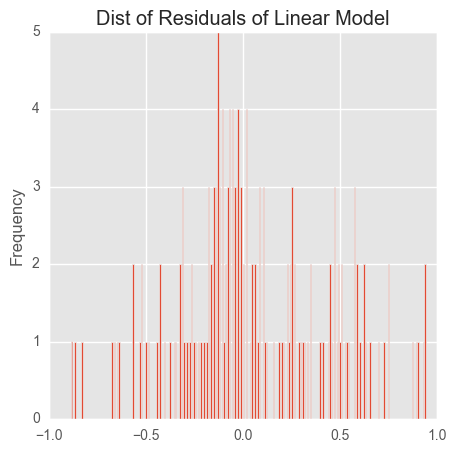

In [92]:
model_2.resid.plot(kind = 'hist', bins = 250, figsize = (5, 5),title='Dist of Residuals of Linear Model')

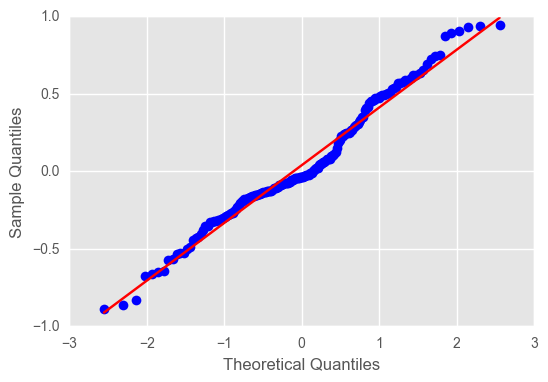

In [93]:
sm.qqplot(model_2.resid, line = 's')

pass

In [94]:
# that worked better but now I want to try lasso Regression

# Lasso Regression 

In [95]:
sampled_df_2 = return_sampled_df(train_df)
sampled_2_X = sampled_df_2[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']]
sampled_2_y = sampled_df_2.Vote_Pct

0    2797
1      93
Name: inducted, dtype: int64
1    93
0    93
Name: inducted, dtype: int64


In [96]:
model_lasso_1 = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.00001]).fit(sampled_2_X, sampled_2_y)

In [97]:
np.sqrt(-cross_validation.cross_val_score(model_lasso_1, sampled_2_X, sampled_2_y, scoring="mean_squared_error", cv = 5))

array([ 0.33680134,  0.34366755,  0.35186173,  0.35162238,  0.36209893])

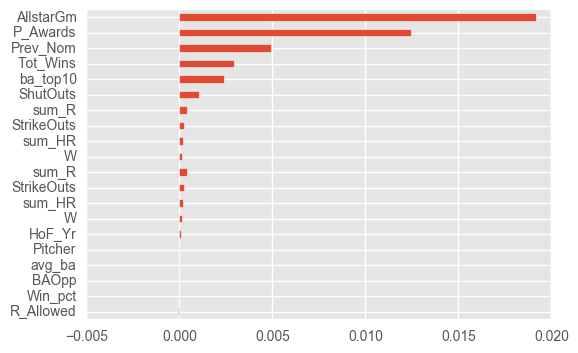

In [98]:
coef = pd.Series(model_lasso_1.coef_, index = sampled_2_X.columns)
important_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
important_coef.plot(kind = "barh")

  Similar to the model in Statsmodels, where I used P values to whittle down the features to include, previous nominations, individual awards ('P-Awards'), and allstar games seem to be important features. 

In [99]:
#predict
val_X_2 = return_sampled_df(val_X)

val_y_2 = val_X_2.Vote_Pct
val_X_2 = val_X_2[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']]

pred_train = model_lasso_1.predict(sampled_2_X)
pred_test = model_lasso_1.predict(val_X_2)

print("Train RMSE:", np.sqrt(metrics.mean_squared_error(sampled_2_y,pred_train)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(val_y_2,pred_test)))

0    1125
1      31
Name: inducted, dtype: int64
1    31
0    31
Name: inducted, dtype: int64
Train RMSE: 0.320639595285
Test RMSE: 0.403389820585


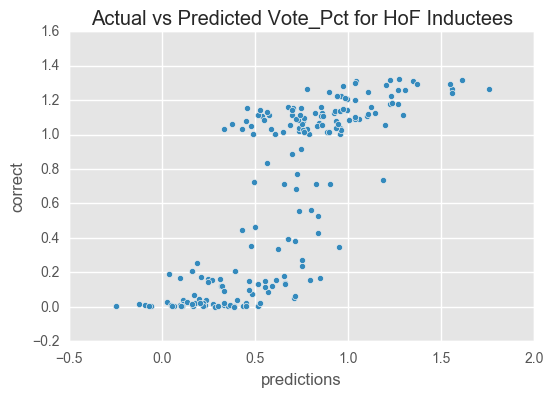

In [100]:
predictions = model_lasso_1.predict(sampled_2_X)
predict = pd.DataFrame({
        "predictions": predictions,
        "correct": sampled_2_y,
        "residual": sampled_2_y - predictions
})
predict.plot(x = "predictions", y = "correct",kind = "scatter",title='Actual vs Predicted Vote_Pct for HoF Inductees')

# Binary Classification

In [101]:
X = train_df

y = train_df.Vote_Pct

train_X, val_X, train_y, val_y = cross_validation.train_test_split(X, y, train_size = .6, random_state = 0)

In [102]:
# downsample, and first use all variables
train_X_bc = return_sampled_df(train_X)
train_y_bc = train_X_bc.inducted
train_X_bc = train_X_bc[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']]


0    1672
1      62
Name: inducted, dtype: int64
1    62
0    62
Name: inducted, dtype: int64


In [103]:
X = train_X_bc
c = train_y_bc

model = linear_model.LogisticRegression().\
    fit(X, c)

In [104]:
model.score(X, c)

0.88709677419354838

In [105]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    c,
    rownames = ['Hypothesized Inducted'],
    colnames = ['True Inducted'])

True Inducted,0,1
Hypothesized Inducted,,
0,54,6
1,8,56


In [106]:
# test
test_c_hat = model.predict(val_X[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']])
test_c = val_X.inducted

In [107]:
pd.crosstab(test_c_hat,
    test_c,
    rownames = ['Hypothesized Inducted'],
    colnames = ['True Inducted'])

True Inducted,0,1
Hypothesized Inducted,,
0,908,9
1,217,22


In [108]:
model.score(val_X[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']], test_c)

0.80449826989619377

In [109]:
# test data!!! (put aside)
model.score(test_df[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']], test_df.inducted)

0.82157676348547715

### Removing features

In [110]:
train_X_bc = return_sampled_df(train_X)
train_y_bc = train_X_bc.inducted
train_X_bc = train_X_bc[[ 'P_Awards',
       'StrikeOuts','ba_top10', 'sum_R']]

X = train_X_bc
c = train_y_bc

model = linear_model.LogisticRegression().\
    fit(X, c)

0    1672
1      62
Name: inducted, dtype: int64
1    62
0    62
Name: inducted, dtype: int64


In [111]:
model.score(X, c)

0.88709677419354838

In [112]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    c,
    rownames = ['Hypothesized Inducted'],
    colnames = ['True Inducted'])

True Inducted,0,1
Hypothesized Inducted,,
0,53,5
1,9,57


In [113]:
# test
test_c_hat = model.predict(val_X[['P_Awards',
       'StrikeOuts','ba_top10', 'sum_R']])
test_c = val_X.inducted

In [114]:
pd.crosstab(test_c_hat,
    test_c,
    rownames = ['Hypothesized Inducted'],
    colnames = ['True Inducted'])

True Inducted,0,1
Hypothesized Inducted,,
0,938,10
1,187,21


In [115]:
model.score(val_X[['P_Awards',
       'StrikeOuts','ba_top10', 'sum_R']], test_c)

0.82958477508650519

In [116]:
# test data!!! (put aside)
model.score(test_df[['P_Awards',
       'StrikeOuts','ba_top10', 'sum_R']], test_df.inducted)

0.83264177040110654

# Random Forest

In [117]:
# downsample, and first use all variables
train_X_bc = return_sampled_df(train_X)
train_y_bc = train_X_bc.inducted
train_X_bc = train_X_bc[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']]

X = train_X_bc
c = train_y_bc

model = tree.DecisionTreeClassifier(max_depth = 4,
    random_state = 0).\
        fit(X,c)

0    1672
1      62
Name: inducted, dtype: int64
1    62
0    62
Name: inducted, dtype: int64


In [118]:
cross_validation.cross_val_score(model, X,c, cv = 10).mean()

0.74761904761904752

In [119]:
sorted(zip(model.feature_importances_, X.columns.values), reverse = True)

[(0.4354287885359468, 'W'),
 (0.12881829023827046, 'P_Awards'),
 (0.11552150200682262, 'AllstarGm'),
 (0.1089078142543087, 'Tot_Wins'),
 (0.097874669672989842, 'ba_top10'),
 (0.063252741067453447, 'Prev_Nom'),
 (0.050196194224208117, 'R_Allowed'),
 (0.0, 'sum_R'),
 (0.0, 'sum_HR'),
 (0.0, 'avg_ba'),
 (0.0, 'Win_pct'),
 (0.0, 'StrikeOuts'),
 (0.0, 'ShutOuts'),
 (0.0, 'Pitcher'),
 (0.0, 'HoF_Yr'),
 (0.0, 'BAOpp')]

In [120]:
# test data!!! (put aside)
model.score(test_df[['HoF_Yr', 'AllstarGm',
       'Prev_Nom', 'W', 'Win_pct', 'Tot_Wins', 'P_Awards', 'BAOpp',
       'StrikeOuts', 'ShutOuts', 'R_Allowed', 'ba_top10', 'avg_ba', 'sum_R',
       'sum_HR', 'Pitcher']], test_df.inducted)

0.72199170124481327

# Best Test accuracy of the Logistic regression/decision tree for binary classification: 

Logistic Regression with features: 'P_Awards',
       'StrikeOuts','ba_top10', 'sum_R'

In [121]:
# Make final model with all data
train_X_all = return_sampled_df(df_clean)
train_y_all = train_X_all.inducted
train_X_all = train_X_all[[ 'P_Awards',
       'StrikeOuts','ba_top10', 'sum_R']]

X = train_X_all
c = train_y_all

model = linear_model.LogisticRegression().\
    fit(X, c)

0    3497
1     116
Name: inducted, dtype: int64
1    116
0    116
Name: inducted, dtype: int64


In [122]:
model.score(X, c)

0.81465517241379315

In [123]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    c,
    rownames = ['Hypothesized Inducted'],
    colnames = ['True Inducted'])

True Inducted,0,1
Hypothesized Inducted,,
0,92,19
1,24,97
